# Setup
## Import modules

In [8]:
import torchvision
test = torchvision.models.resnet50(pretrained=True)

/home/ucloud/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ucloud/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from math import sqrt, ceil
import sys
from tqdm import tqdm

# Import YOLOv5 helper functions
sys.path.append('/home/ucloud/EUMothModel')
from tutils.yolo_helpers import box_iou, xywh2xyxy, non_max_suppression
from tutils.implicit_mount import *
from tutils.dataloader import *

from tensorboardX import SummaryWriter

backend = None

## Setup environment

In [2]:
# def class_counting(paths, class_handles):
#     """
#     Count the number of each class in the labels
#     """
#     class_count = [torch.zeros(n) for n in class_handles["n_classes"]]
#     for path in paths:
#         for ctype, cls in enumerate(path.split("/")[2::-1]):
#             class_count[ctype][class_handles["class_to_idx"][ctype][cls]] += 1
#     return class_count

from collections import Counter

def class_counting(paths, class_handles):
    """
    Count the number of each class in the labels
    """
    counts = [Counter() for _ in class_handles["n_classes"]]
    for path in paths:
        components = path.split("/")[2::-1]
        for ctype, cls in enumerate(components):
            counts[ctype][class_handles["class_to_idx"][ctype][cls]] += 1

    # Convert to NumPy arrays
    counts = [np.array(list(counter.values())) for counter in counts]

    return counts

In [3]:
def create_hierarchy(paths, class_handles):
    """
    Create a hierarchy of classes
    """
    hierarchy = [[[]] * n for i, n in enumerate(class_handles["n_classes"]) if i != 0]  # Create empty lists for each level
    processed_leaves = [0] * class_handles["n_classes"][0]  # Keep track of which leaves have been processed

    for path in paths:
        components = path.split("/")[2::-1]
        indices = [class_handles["class_to_idx"][ctype][cls] for ctype, cls in enumerate(components)]
        # print(indices)
        if processed_leaves[indices[0]] == 0:  # If the leaf has not been processed yet
            processed_leaves[indices[0]] = 1
        else:
            continue  # Skip this leaf

        for i in range(1, len(indices)):
            i -= 1
            parent = indices[i + 1]
            child = indices[i]
            
            if not hierarchy[i][parent]:
                hierarchy[i][parent] = [child]
            else:
                hierarchy[i][parent].append(child)  # Append the child to the parent's list
    
    for i in range(1, len(hierarchy)):
        for j in range(len(hierarchy[i])):
            hierarchy[i][j] = list(set(hierarchy[i][j]))

    return hierarchy

def create_mask(indices, s, **kwargs):
    t = torch.zeros(s, **kwargs, requires_grad=False)
    t -= 100
    t[indices] = 0
    return t

def mask_hierarchy(hierarchy, **kwargs):
    """
    Create a mask for each level of the hierarchy.
    """
    masks = []
    for level in hierarchy:
        n = sum([len(indices) for indices in level])
        masks.append([create_mask(indices, n, **kwargs) for indices in level])

    return [torch.stack(level) for level in masks]

def create_random_P(n_classes, **kwargs):
    """
    Create a random P matrix for testing with the given number of classes at each level.
    """
    P = [None] * len(n_classes)
    P[0] = torch.rand(n_classes[0], **kwargs)  # Create a random P matrix for the leaf level
    P[0] = F.log_softmax(P[0], dim=-1)  # Normalize along class dimension
    for i, n in enumerate(n_classes):
        if i == 0:
            continue
        P[i] = P[i-1] * masks[i-1]  # Multiply by the mask of the previous level
        P[i] = torch.logsumexp(P[i], dim=-1)

    return P

def correctness_score(P, logits=False):
    """
    Compute the correctness score of the hierarchy, taking batch dimension into account.
    """
    global masks
    if P[0].shape[0] == 1:
        P = [p.squeeze(0) for p in P]  # Remove batch dimension
    batched = len(P[0].shape) != 1  # Check if P is batched
    bs = 1 if batched else P[0].shape[0]  # Get the batch size
    correctness = torch.ones(bs, dtype=P[0].dtype, device=P[0].device)  # [batch_size]
    if batched:
        correctness = correctness.unsqueeze(0)  # [1, batch_size]

    for i, mask in enumerate(masks):
        if batched:
            probs = P[i]  # Assuming P has shape [batch_size, num_masks, num_classes]
        else:
            probs = P[i].unsqueeze(0)  # Assuming P has shape [num_masks, num_classes]

        if logits:
            # probs = torch.exp(probs - torch.logsumexp(probs, dim=1, keepdim=True))
            probs = F.softmax(probs, dim=1)
            probs = probs / torch.sum(probs, dim=1, keepdim=True)  # Normalize along class dimension
        else:
            probs = probs / torch.sum(probs, dim=1, keepdim=True)

        correctness = torch.matmul(probs * correctness, mask.T)

    return correctness.sum(dim=1).mean().to(P[0].dtype)  # Average over the batch

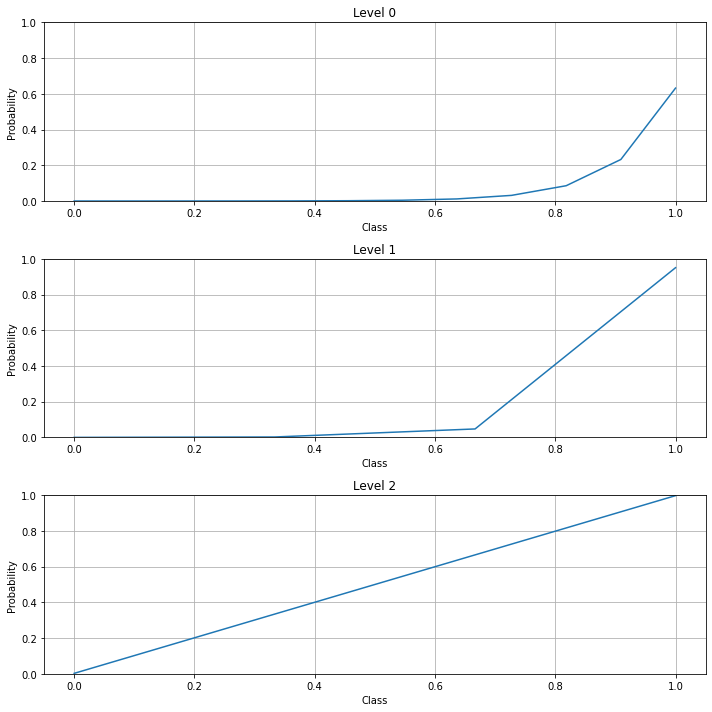

In [4]:
tmasks = mask_hierarchy([[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]],[[0,1], [2,3]]], dtype=torch.long)

tleaf_logits = torch.tensor([[i for i in range(12)],[11 - i for i in range(12)]]).float()

ty0 = F.log_softmax(tleaf_logits[0].unsqueeze(0), dim=1)

# Hierarchical aggregation
# For level 1
ty1 = torch.logsumexp(ty0.unsqueeze(2) + tmasks[0].T, dim=1)

# For level 2
ty2 = torch.logsumexp(ty1.unsqueeze(2) + tmasks[1].T, dim=1)

tps = [ty0.exp(), ty1.exp(), ty2.exp()]
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i, ax in enumerate(axs.ravel()):
    tp = tps[i]
    ax.plot(np.linspace(0,1,tp.shape[1]), tp.squeeze().numpy())
    ax.set_title(f"Level {i}")
    ax.set_xlabel("Class")
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 1)
    ax.grid()
plt.tight_layout()
plt.show()


## Helpers

In [5]:
# test_cs = []
# css = []

# for cs in range(1000):
#     correct_P = [torch.zeros(10, n).to(device=device,dtype=dtype) for n in num_classes]
#     test_species = [i.item() for i in torch.randint(0, num_classes[0], (10, )).to(dtype=torch.long)]
#     test_genera = [torch.where(masks[0][:,i] == 1)[0].item() for i in test_species]
#     test_family = [torch.where(masks[1][:,i] == 1)[0].item() for i in test_genera]
#     for i, (s, g, f) in enumerate(zip(test_species, test_genera, test_family)):
#         # print(i, s, g, f)
#         correct_P[0][i,s] = 1
#         correct_P[1][i,g] = 1
#         correct_P[2][i,f] = 1

#     r = cs / 1000
    
#     for i, p in enumerate(correct_P):
#         correct_P[i] = p * (1 - r) + r * torch.rand_like(p)

#     test_cs += [correctness_score(correct_P, logits=False)]
#     css += [torch.tensor(r)]

# test_cs = torch.stack(test_cs)
# css = torch.stack(css)

In [6]:
# import seaborn as sns
# from matplotlib import gridspec

# # Create three subplots, each with its y-axis, to plot the counts of the classes in each hierarchy level (species, genus, family)
# fig, axs = plt.subplots(1, 3, sharey=False, figsize=(15, 5))
# grid = gridspec.GridSpec(1, 3, wspace=0.25, hspace=0.15)

# # Plot the counts of the classes in each hierarchy level (species, genus, family) in a log10-scale
# for i in range(3):
#     ax = axs[i]
#     counts = (test[i].numpy() + 1)
#     counts.sort()
#     sns.barplot(ax=ax, x=full_dataset.classes[i], y=counts, width=1)
#     ax.set_title(["Species", "Genus", "Family"][i])
#     if i == 0:
#         ax.set_ylabel("Count")
#     ax.set_yscale("log")  # Set the y-axis to log scale
#     ax.xaxis.set_visible(False)
#     ax.axes.get_xaxis().set_ticks([])

# # Save the figure
# plt.savefig("../plots/class_counts_logscale.png", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)
# plt.close()

In [7]:
# weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
class create_image_preprocessing:
    def __init__(self, weights):
        self.transform = weights.transforms.func(crop_size=256)
        self.isize = self.transform.resize_size[0]
        self.mean = self.transform.mean
        self.std = self.transform.std

    def __call__(self, images):
        """Preprocess images for EfficientNet."""
        images = torchvision.transforms.Resize((self.isize, self.isize), antialias=True)(images)
        return self.transform(images)

image_preprocessing = create_image_preprocessing(weights)

def denormalize(tensor, mean=image_preprocessing.mean, std=image_preprocessing.std):
    """Denormalize a tensor."""
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(torch.float32)
    std = torch.tensor(std).view(1, 3, 1, 1).to(torch.float32)
    return tensor.cpu().to(torch.float32) * std + mean

## Hyperparameters
skip = 0 # Number of batches to skip (used to resume script from a specific batch)
batch_size = 128 # Batch size for chunked loading of images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype=torch.bfloat16
real_class_index = 0 # The real class index of the species to fine-tune on (6 for the initial model; insectGBIF-1280m6.pt)
inference_size = 640 # The size of the images to run inference on (1280 for the initial model; insectGBIF-1280m6.pt)

# ERDA data transfer setup
if backend is not None:
    backend.stop()
backend = IOHandler(verbose = False, clean=True)
backend.start()
backend.cd("AMI_GBIF_Pretraining_Data/rebalanced75_without_larvae")
backend.cache_file_index(skip=skip)

# Dataset and dataloader setup
# Dataset and dataloader setup
remote_iterator = RemotePathIterator(
        backend,
        batch_size=32,
        max_queued_batches=5,
        n_local_files=5*32*2,
    )

full_dataset = RemotePathDataset(
    remote_iterator,
    prefetch=1*batch_size,
    transform=image_preprocessing,
    # device=device, 
    dtype=dtype, 
    hierarchical=True,
    return_remote_path=False,
    return_local_path=True,
    verbose=False
)

class_counts = class_counting(full_dataset.remote_path_iterator.remote_paths, full_dataset.class_handles)
hierarchy = create_hierarchy(full_dataset.remote_path_iterator.remote_paths, full_dataset.class_handles)
masks = mask_hierarchy(hierarchy, device=device, dtype=dtype)

ri_train, ri_val, ri_test = remote_iterator.split(proportion=[0.05, 0.05, 0.9])
datasets = [RemotePathDataset(
    ri,
    prefetch=3*batch_size,
    transform=image_preprocessing,
    # device=device, 
    dtype=dtype,
    hierarchical=True,
    return_remote_path=False,
    return_local_path=True,
    verbose=False
) for ri in [ri_train, ri_val, ri_test]]
datasets[0].class_handles = full_dataset.class_handles
datasets[1].class_handles = full_dataset.class_handles
datasets[2].class_handles = full_dataset.class_handles
train, val, test = [CustomDataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=8) for dataset in datasets]

lengths = [len(dataset) for dataset in datasets]

Connected to sftp://asgersvenning%40ecos.au.dk:@io.erda.au.dk:2222
Local directory: /tmp/tmpua_4itdl
IOHandler.start() is unsafe. Use IOHandler.__enter__() instead if possible.
OBS: Remember to call IOHandler.stop() when you are done.


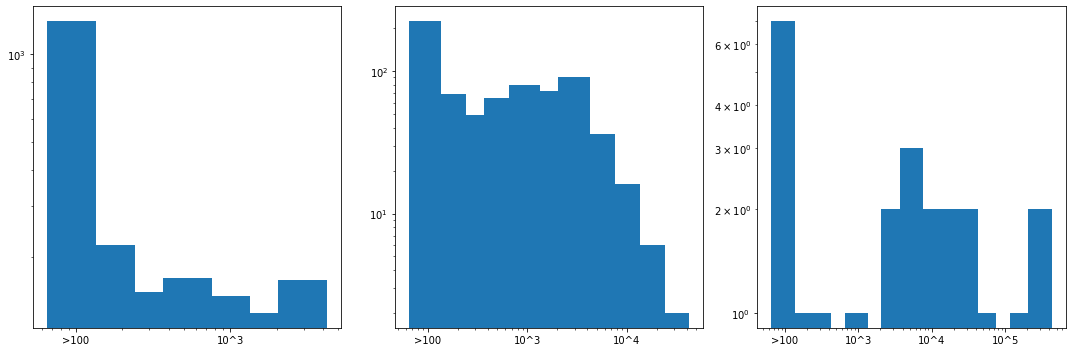

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs.ravel()):
    counts = class_counts[i]
    ax.hist(counts + 100, bins=10 ** np.arange(2, int(np.ceil(np.log10(counts.max()))), step=0.25), rwidth=0.9, align="left", log=True)
    ax.set_xscale("log")
    ax.set_xticks([10**i for i in range(2, int(np.ceil(np.log10(counts.max()))))])
    ax.set_xticklabels([">100" if i == 2 else f"10^{i}" for i in range(2, int(np.ceil(np.log10(counts.max()))))])

plt.tight_layout()
plt.show()

## Define model

In [9]:
torch.logsumexp(masks[0].T, dim=0).exp()

tensor([ 3.0156,  5.0000,  1.0000,  2.0000,  1.0000,  1.0000,  5.9688,  1.0000,
         1.0000,  1.0000,  1.0000, 14.9375,  3.0156,  2.0000,  2.0000,  1.0000,
         3.9844,  2.0000,  1.0000,  3.9844,  1.0000,  1.0000,  1.0000,  5.0000,
         1.0000, 18.0000, 21.0000,  1.0000,  3.0156,  3.0156,  1.0000,  2.0000,
         2.0000,  5.9688,  3.0156,  3.9844,  1.0000,  3.9844,  9.9375,  1.0000,
         1.0000,  9.0625,  1.0000,  1.0000,  1.0000,  1.0000,  2.0000,  2.0000,
         1.0000,  1.0000,  2.0000,  1.0000,  2.0000, 23.8750,  1.0000,  1.0000,
         1.0000,  1.0000,  5.9688,  1.0000,  1.0000,  1.0000,  1.0000,  5.9688,
         1.0000,  1.0000,  2.0000,  2.0000,  9.9375,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  3.0156,  1.0000,  3.0156,  1.0000,  2.0000,
         3.0156,  5.0000,  1.0000,  1.0000,  3.9844,  1.0000,  1.0000,  9.0625,
         3.0156,  2.0000,  1.0000,  1.0000,  1.0000, 12.9375,  1.0000,  3.9844,
         1.0000,  1.0000,  1.0000,  1.00

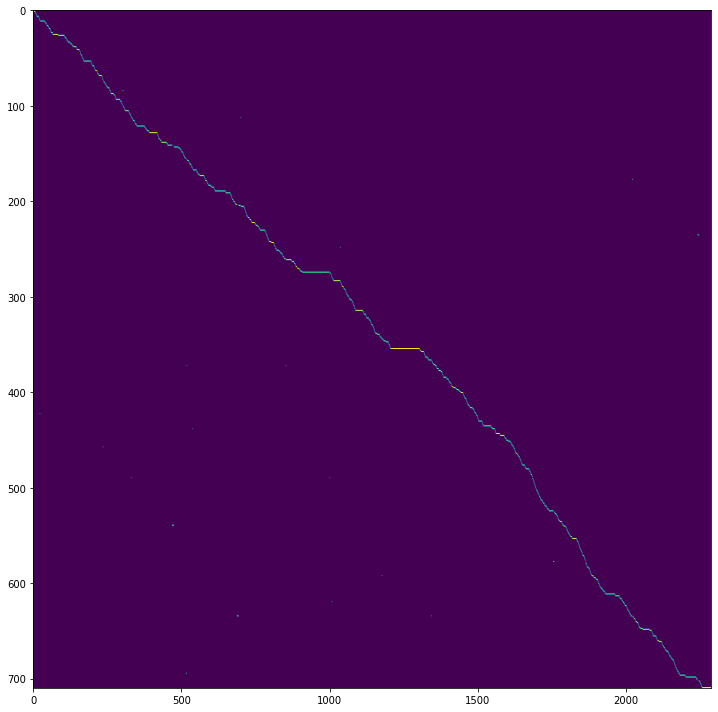

In [10]:
plt.figure(figsize=(10, 10))
# Set aspect ratio to 1
plt.imshow(masks[0].cpu().float().exp())
plt.gca().set_aspect(masks[0].shape[1] / masks[0].shape[0])
plt.tight_layout()

In [29]:
# Model definition
model = torchvision.models.efficientnet_b0(weights=None).half().train(False)
num_features = [k for k in [j for j in [i for i in model.children()][0].children()][-1].children()][0].out_channels
num_classes = datasets[0].n_classes

class HierarchicalClassifier(nn.Module):
    def __init__(self, num_features, num_classes, masks):
        super(HierarchicalClassifier, self).__init__()
        self.silu = nn.SiLU()
        self.dropout1 = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(num_features, device=device, dtype=dtype)
        self.linear1 = nn.Linear(num_features, 1024, device=device, dtype=dtype)
        self.bn2 = nn.BatchNorm1d(1024, device=device, dtype=dtype)
        self.dropout2 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(1024, 1024, device=device, dtype=dtype)
        self.bn3 = nn.BatchNorm1d(1024, device=device, dtype=dtype)
        self.dropout3 = nn.Dropout(0.1)
        self.linear3 = nn.Linear(1024, 512, device=device, dtype=dtype)
        self.bn4 = nn.BatchNorm1d(512, device=device, dtype=dtype)
        self.dropout4 = nn.Dropout(0.1)
        # self.linear_logits = [nn.Linear(512, ncls, device=device, dtype=dtype) for ncls in num_classes]
        self.leaf_logits = nn.Linear(512, num_classes[0], device=device, dtype=dtype)
        self.bn5 = nn.BatchNorm1d(num_classes[0], device=device, dtype=dtype)
        self.masks = masks.copy()
        
    def forward(self, x):
        x = self.dropout1(x)
        x = self.bn1(x)
        x = self.linear1(x)
        x = self.bn2(x)
        x = self.silu(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        x = self.bn3(x)
        x = self.silu(x)
        x = self.dropout3(x)
        x = self.linear3(x)
        x = self.bn4(x)
        x = self.silu(x)
        x = self.dropout4(x)
        x = self.leaf_logits(x)
        y = self.bn5(x)
        y0 = F.log_softmax(y, dim = 1)
        y1 = F.log_softmax(torch.logsumexp(y0.unsqueeze(2) + self.masks[0].T, dim = 1), dim = 1)
        y2 = F.log_softmax(torch.logsumexp(y1.unsqueeze(2) + self.masks[1].T, dim = 1), dim = 1)
        return [y0, y1, y2]
        # return [linear(x) for linear in self.linear_logits]

model.to(device=device, dtype=dtype)
# # Freeze backbone
# model.features.requires_grad_(True)
# for layer in model.features.children():
#     if isinstance(layer, nn.BatchNorm2d):
#         layer.train(True)
model.classifier = HierarchicalClassifier(num_features, num_classes, masks)
model.eval()
pass

In [12]:
# import statsmodels.api as sm
# import pandas as pd

# # Assuming class_counts[0] and pred[0][0].exp().float().cpu().numpy() are your data
# x_data = class_counts[0]  # Replace with your data
# y_data = pred[0][0].exp().float().cpu().numpy()  # Replace with your data

# # Fit Poisson regression as before
# x_with_const = sm.add_constant(np.log(x_data))
# poisson_model = sm.GLM(y_data, x_with_const, family=sm.families.Poisson())
# poisson_results = poisson_model.fit()
# x_vals = np.linspace(min(np.log(x_data)), max(np.log(x_data)), 100)
# x_vals_with_const = sm.add_constant(x_vals)
# y_vals = poisson_results.predict(x_vals_with_const)

# # Create a DataFrame for easier data manipulation
# df = pd.DataFrame({'x': x_data, 'y': y_data})

# # Explicitly setting the minimum and maximum values for the x-axis bins
# x_min = min(x_data)
# x_max = max(x_data)

# # Create log-spaced bins that span the entire range of x
# bin_edges = np.logspace(np.log10(x_min), np.log10(x_max), num=10)

# # Verify that bin edges cover the x-range
# print(f"Minimum x value: {x_min}, Maximum x value: {x_max}")
# print(f"Bin edges: {bin_edges}")

# # Use the bin edges in pd.cut()
# binned_statistic = df.groupby(pd.cut(df['x'], bins=bin_edges, include_lowest=True))

# median = binned_statistic['y'].median()
# median_v = 10 ** (np.log10(np.array([[j.left, j.right] for j in [i[0] for i in median.items()]])).sum(axis = 1) / 2)
# q1 = binned_statistic['y'].quantile(0.25)
# q3 = binned_statistic['y'].quantile(0.75)

# plt.figure(figsize=(10, 10))

# # # Add median-quantile error bars (color = black)
# plt.errorbar(median_v, median, yerr=[median - q1, q3 - median], fmt='o', label='Median-Q1-Q3', color='black')

# # Plot everything
# plt.scatter(x_data, y_data, label='Data', alpha=0.6)
# plt.plot(np.exp(x_vals), y_vals, 'r-', label='Poisson Regression')

# plt.gca().set_xscale("log")
# plt.gca().set_yscale("log")
# plt.legend()
# plt.tight_layout()
# plt.show()


### Test that the model works

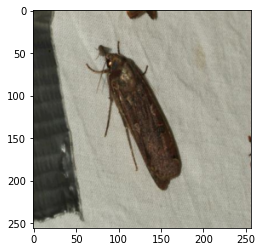

torch.Size([3, 256, 256])
['Tyta_luctuosa_Denis_Schiffermller_1775', 'Idaea', 'Noctuidae']
___________________
|Number of classes|
|_________________|
| species  : 2286 |
|  genera  :  710 |
| families :   25 |
|_________________|
Correctness score: 0.0020446777


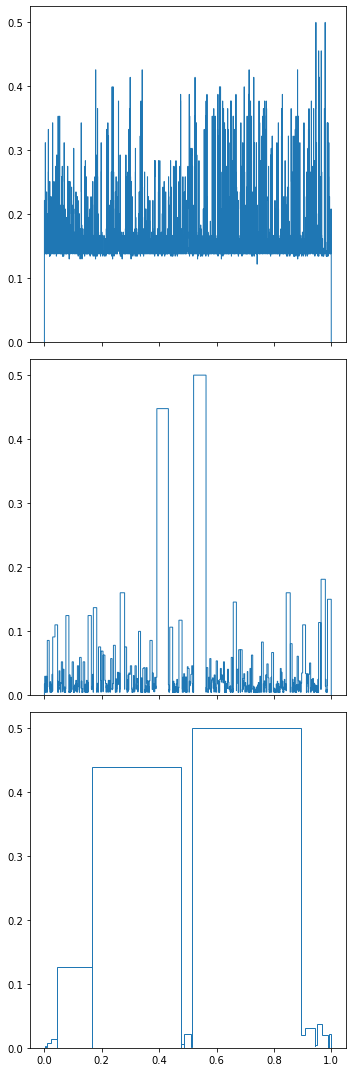

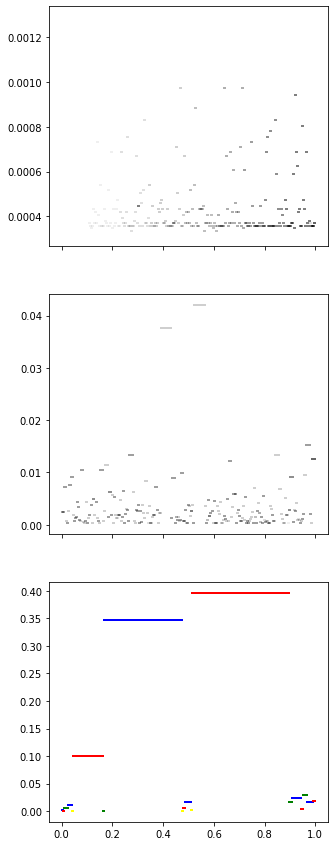

In [39]:
model.eval()

# Load and preprocess your test data
test = torchvision.io.read_image("../datasets/fine_tuning/images/train/9.jpg")
test = image_preprocessing(test).to(device=device, dtype=dtype)

test_img = denormalize(test).cpu().float().squeeze(0).numpy().transpose(1, 2, 0)
plt.imshow(test_img)
plt.show()

print(test.shape)
test = torch.stack([test, test, test])


# Perform inference
with torch.no_grad():
    pred = model(test)

    # Print first prediction
    pred1 = [p[0].softmax(-1).argmax(-1).cpu().numpy() for p in pred]
    pred1_readable = [full_dataset.idx_to_class[i][int(p)] for i, p in enumerate(pred1)]
    print(pred1_readable)
    
    fig, axs = plt.subplots(3, 1, figsize=(5, 15))

    for i, (p, ax) in enumerate(zip(pred, axs.ravel())):
        p = p[0].softmax(-1).cpu().float().numpy()
        p /= p.max(-1) * 2
        if i > 0:
            xs = np.cumsum([0] + [len(j) for j in hierarchy[i-1]]).astype(np.float32)
            xs /= xs.max()
        else:
            xs = np.linspace(0, 1, p.shape[0] + 1)
        # print(p)
        ax.stairs(
            p, 
            xs,
            label = ["Species", "Genus", "Family"][i]
        )
        if i != (len(pred) -1):
            ax.set_xticklabels([])

plt.tight_layout()

# Print the prediction
print(f"___________________\n|{'Number of classes':^17}|\n|_________________|")
for ctype, i in zip(["species", "genera", "families"], range(len(pred))):
    print(f'|{ctype:^10}:{pred[i].shape[1]:>5} |')
print("|_________________|")

print(f'Correctness score: {correctness_score(pred, logits=True)**(-1/2):.10f}')

def plot_horizontal_segments(ax, y_levels, segment_lengths, colors=None):
    """
    Plots horizontal line segments on a given Matplotlib axis.

    Parameters:
    ax (matplotlib.axis): The axis on which to plot.
    y_levels (array-like): The y-levels at which to plot the line segments.
    segment_lengths (array-like): The lengths of each line segment.
    colors (list, optional): List of colors to use for the segments. Defaults to None.
    """
    
    # Default color list; used if no colors are provided
    default_colors = ['red', 'green', 'blue', 'yellow']
    
    # Use provided colors or default colors
    colors = colors if colors else default_colors
    
    # Validate lengths
    if len(y_levels) != len(segment_lengths):
        raise ValueError("Lengths of y_levels and segment_lengths must match.")

    x_start = 0
    for i, (y, length) in enumerate(zip(y_levels, segment_lengths)):
        x_end = x_start + length
        ax.plot([x_start, x_end], [y, y], linewidth=2, color=colors[i % len(colors)])
        x_start = x_end

def plot_hierarchy(probs, child_indices):
    probs = [p[0].softmax(0).cpu().float().numpy() for p in probs]

    # Find the correct order of leafs such that they come in the order of which parent they belong to
    leaf_order = []
    for i, indices in enumerate(child_indices[0]):
        leaf_order += indices

    fig, axs = plt.subplots(3, 1, figsize=(5, 15))
    # fig = plt.figure(figsize=(5, 15))

    for i, p in enumerate(probs):
        if i == 0:
            p = p[leaf_order]
        if i > 0:
            # xs = np.cumsum([] + [len(j) for j in child_indices[i-1]]).astype(np.float32)
            # xs /= xs.max()
            xs = np.array([len(j) for j in child_indices[i-1]]).astype(np.float32)
            xs /= xs.sum()
        else:
            # xs = np.linspace(0, 1, p.shape[0] + 0)
            xs = np.ones(p.shape[0]).astype(np.float32)
            xs /= xs.sum()
        if i != len(probs) - 1:
            parents = [None] * len(xs)
            for parent, children in enumerate(child_indices[i]):
                for child in children:
                    parents[child] = parent
            assert None not in parents, f"None in parents: {parents}"
        else:
            parents = None
        # print(parents)
        # print(p)
        # assert len(xs) == len(p) and (len(xs) == len(parents) or parents is None), f"Lengths of xs ({len(xs)}), p ({len(p)}) and parents ({len(parents)}) do not match."
        plot_horizontal_segments(axs[i], p, xs, colors=[f'#000000{int(9 * i / max(parents))}{int(9 * (i / max(parents) // 1))}' for i in parents] if parents else None)
        if i != (len(probs) -1):
            axs[i].set_xticklabels([])

# Plot the hierarchy
plot_hierarchy(pred, hierarchy)

In [33]:
full_dataset.idx_to_class[2][6]

'Drepanidae'

In [38]:
class_counts[0]

array([4610, 4610, 4610, ...,    1,    1,    1])

In [28]:
val.dataset._shutdown_and_reset()

In [26]:
test_batch = next(iter(val))

In [51]:
def confusion_matrix(model, batch, name, writer):
    for level in range(3):
        batch[0] = batch[0].to(device=device, dtype=dtype)

        with torch.no_grad():
            pred = model(batch[0])
            pcls = pred[level].softmax(-1).argmax(-1).cpu().numpy()
            
            true = batch[1][level].cpu().numpy()

        cm = np.zeros((num_classes[level] + 1, num_classes[level] + 1))
        for p, t in zip(pcls, true):
            cm[p, t] += 1
        cm /= cm.sum(axis=0) + 1
        
        plt.figure(figsize=(10, 10))
        plt.imshow(cm)
        plt.colorbar()
        plt.tight_layout()
        writer.add_figure(f"Confusion Matrix {level}", plt.gcf())

    return

confusion_matrix(model, test_batch, "testplots", writer)
# del test_batch

In [48]:
writer

In [14]:
# Check memory usage
torch.cuda.empty_cache()
print(f"Memory usage: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Memory usage: 0.03 GB


# Training

## Setup loss and optimizer

name 'test_batch' is not defined
name 'images' is not defined
name 'preds' is not defined
name 'loss' is not defined
name 'lcorr' is not defined
name 'combined_loss' is not defined
name 'loss_fns' is not defined
Memory usage: 0.05 GB
Cached GPU memory: 0.171966464 GB
species : min=0.27 | max=3.30 | mean=1.00 | std=0.91
genus   : min=0.37 | max=5.50 | mean=1.00 | std=1.02
family  : min=0.31 | max=5.78 | mean=1.00 | std=1.21


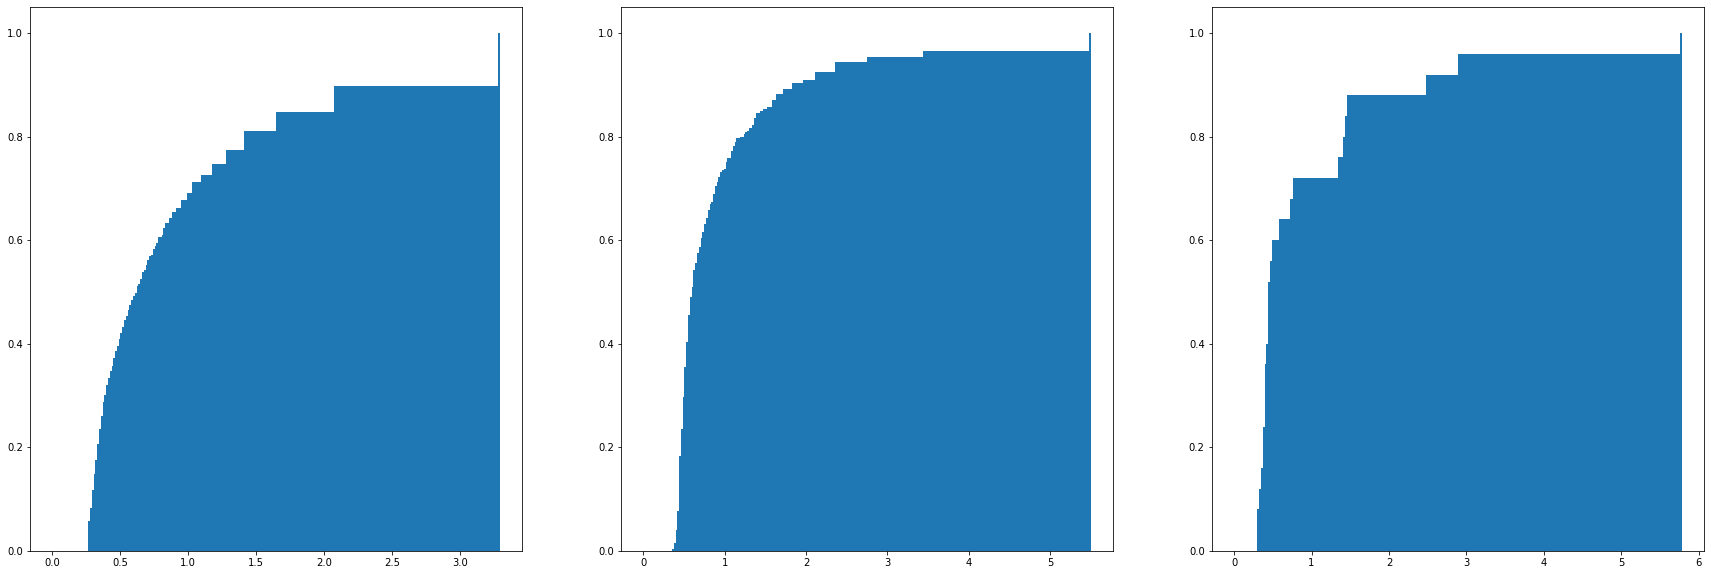

In [38]:
import gc

try:
    del test_batch
except Exception as e:
    print(e)
try:
    del images
except Exception as e:
    print(e)
try:
    del labels
except Exception as e:
    print(e)
try:
    del batch
except Exception as e:
    print(e)
try:
    del preds
except Exception as e:
    print(e)
try:
    del pred
except Exception as e:
    print(e)
try:
    del loss
except Exception as e:
    print(e)
try:
    del lcorr
except Exception as e:
    print(e)
try:
    del combined_loss
except Exception as e:
    print(e)
try:
    del loss_fns
except Exception as e:
    print(e)
try:
    del optimizer
except Exception as e:
    print(e)
try:
    del lr_scheduler
except Exception as e:
    print(e)
try:
    del class_weights
except Exception as e:
    print(e)

gc.collect()
torch.cuda.empty_cache()
print(f"Memory usage: {torch.cuda.memory_allocated()/1e9:.2f} GB")
print(f"Cached GPU memory: {torch.cuda.memory_reserved() / 1e9} GB")

epochs = 3
lr = 5e-2

loss_fn = nn.CrossEntropyLoss(reduction="none")
def loss_correct(logits):
    return correctness_score(logits, logits=True) ** (-1/2)
# RMSProp optimizer with decay 0.9 and momentum 0.9; batch norm momentum 0.99; weight decay 1e-5; initial learning rate 0.256 that decays by 0.97 every 2.4 epochs
optimizer = optim.AdamW([
    {
        'params' : model.classifier.parameters(),
        'lr' : lr,
        'weight_decay' : 1e-5,
    },
    {
        'params' : model.features.parameters(),
        'lr' : lr / 1e2,
        'weight_decay' : 1e-5,
    }])
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=(1e-3)**(1/(epochs*len(train))), verbose=False)

family_weight, genus_weight, species_weight = 0, 0, 1
loss_weights = [species_weight, genus_weight, family_weight]

class_weights = [torch.tensor(i, device=device, dtype=dtype) for i in class_counts]
class_weights = [1 / (i + 1).log10() for i in class_weights]
class_weights = [i / i.mean() for i in class_weights]
for i in class_weights:
    i.requires_grad = False

[print('{} : min={:.2f} | max={:.2f} | mean={:.2f} | std={:.2f}'.format(["species", "genus  ", "family "][ind], i.min().item(), i.max().item(), i.mean().item(), i.std().item())) for ind, i in enumerate(class_weights)]
pass

fig, axs = plt.subplots(1, 3, figsize=(30,10))
for i, ax in enumerate(axs.ravel()):
    ax.hist(class_weights[i].cpu().float(), bins=250, cumulative=True, range=[0, class_weights[i].cpu().float().max().item()], density=True)
pass

In [32]:
# tensorboard --logdir=/home/ucloud/EUMothModel/tensorboard_logs
# Define the base log directory
base_logdir = "/home/ucloud/EUMothModel/tensorboard_logs"

# List all existing run directories in the base log directory
existing_runs = [d for d in os.listdir(base_logdir) if d.startswith("run")]

# Find the maximum run number among existing directories and increment for the next run
next_run_number = max([int(run[3:]) for run in existing_runs] + [0]) + 1

# Create a new run directory using the incremented run number
logdir = os.path.join(base_logdir, f"run{next_run_number}")

# Create the SummaryWriter with the unique logdir
writer = SummaryWriter(logdir=logdir)

In [37]:
train.dataset._shutdown_and_reset()

Waiting for worker 0 to finish.


AttributeError: 'Thread' object has no attribute 'terminate'

In [19]:
# torch.autograd.set_detect_anomaly(True)

In [33]:
model.train()

for epoch in range(0, epochs):
    # if epoch == 0:
    #     model.features.requires_grad_(True)
    pbar = tqdm(train, total=len(train), desc=f"Epoch {epoch}")
    torch.cuda.empty_cache()
    for batch in pbar:
        images, labels, paths = batch
        images = images.to(device=device, dtype=dtype)
        # icf_weights = [torch.tensor([class_weights[ctype][cls].item() for cls in clses], dtype=dtype, device=device) for ctype, clses in enumerate(labels)]
        icf_weights = [class_weights[ctype][clses] for ctype, clses in enumerate(labels)]
        
        optimizer.zero_grad()
        pred = model(images)
        del images
        loss = [(loss_fn(pred[i], labels[i].to(device)) * icf_weights[i]).mean() for i in range(3)]
        with torch.no_grad():
            lcorr = loss_correct(pred)  # Compute the correctness score of the hierarchy using the logits
        # del pred
        combined_loss = sum([loss[i] * loss_weights[i] for i in range(3)])
        if lcorr < 0:
            break
        combined_loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        
        for i, ltype in enumerate(["species", "genera", "families"]):
            writer.add_scalar(f"Loss/train/{ltype}", loss[i].cpu().float(), pbar.n + len(train) * epoch)
        writer.add_scalar("Loss/train/combined", combined_loss.cpu().float(), pbar.n + len(train) * epoch)
        writer.add_scalar("Loss/train/correctness", lcorr.cpu().float(), pbar.n + len(train) * epoch)
        
        pbar.set_description_str(f"TRAIN: Epoch {epoch} | Correctness {lcorr:.2f} | Family : {loss[2]:.2f} | Genus : {loss[1]:.2f} | Species : {loss[0]:.2f} | Combined : {combined_loss:.2f} | LR: {lr_scheduler.get_last_lr()[0]:.8f} | Memory usage: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        del loss, lcorr, combined_loss
        torch.cuda.empty_cache()
    
    # with torch.no_grad():
    #     pbar = tqdm(val, total=len(val), desc=f"Epoch {epoch}")
    #     for batch in pbar:
    #         images, labels = batch
    #         pred = model(images)
    #         loss = [loss_fns(pred[i], labels[i]) for i in enumerate(pred)]
    #         combined_loss = sum([loss[i] * loss_weights[i] for i in range(len(loss))])
    #         for i, ltype in enumerate(["species", "genera", "families"]):
    #             writer.add_scalar(f"Loss/val/{ltype}", loss[i], epoch)
    #         writer.add_scalar("Loss/val/combined", combined_loss, epoch)
    #         pbar.set_description_str(f"VALIDATION: Epoch {epoch} | Family Loss: {loss[2]} | Genus Loss: {loss[1]} | Species Loss: {loss[0]} | Combined Loss: {combined_loss} | LR: {lr_scheduler.get_last_lr()[0]}")

model.eval()

Epoch 0:   0%|          | 0/550 [00:00<?, ?it/s]

TRAIN: Epoch 0 | Correctness 0.00 | Family : 1.56 | Genus : 6.47 | Species : 7.69 | Combined : 7.69 | LR: 0.04794995 | Memory usage: 0.11 GB:   2%|▏         | 10/550 [00:32<29:32,  3.28s/it] 


KeyboardInterrupt: 

In [108]:
max_width = 30

def format_text(text):
    if len(text) > max_width:
        # Truncate long text
        return text[:(max_width-3)] + "..."
    else:
        # Pad and center shorter text
        padding = max_width - len(text)
        left_padding = padding // 2
        right_padding = padding - left_padding
        return " " * left_padding + text + " " * right_padding

def PlotPredictions(model, loader, n):
    if model.training:
        model_is_training = True
        model.eval()
    else:
        model_is_training = False

    cls_dicts = train.dataset.idx_to_class
    fam_dict, gen_dict, sp_dict = cls_dicts[2], cls_dicts[1], cls_dicts[0]

    with torch.no_grad():
        torch.cuda.empty_cache()
        for batch in loader:
            images, labels, paths = batch
            images = images.to(device=device, dtype=dtype)
            print(images.shape)
            print(labels)
            pred = model(images)
            for i in range(len(images)):
                pfamily, pgenus, pspecies = pred[2][i].argmax(), pred[1][i].argmax(), pred[0][i].argmax()
                tfamily, tgenus, tspecies = labels[2][i], labels[1][i], labels[0][i]

                pfamily, tfamily, pgenus, tgenus, pspecies, tspecies = pfamily.cpu().item(), tfamily.cpu().item(), pgenus.cpu().item(), tgenus.cpu().item(), pspecies.cpu().item(), tspecies.cpu().item()
                print(
                    "pfamily:", pfamily, "tfamily:", tfamily, "pgenus:", pgenus, "tgenus:", tgenus, "pspecies:", pspecies, "tspecies:", tspecies, "\n"
                )
                pfamily, tfamily, pgenus, tgenus, pspecies, tspecies = fam_dict[pfamily], fam_dict[tfamily], gen_dict[pgenus], gen_dict[tgenus], sp_dict[pspecies], sp_dict[tspecies]

                pred_v_truth = f'''
                {"":<9} | {format_text("Predicted"):<{max_width}} | {format_text("Truth"):<{max_width}}
                {"-" * 9} | {"-" * max_width} | {"-" * max_width}
                {"Family":^10}| {format_text(pfamily):<{max_width}} | {format_text(tfamily):<{max_width}}
                {"Genus":^10}| {format_text(pgenus):<{max_width}} | {format_text(tgenus):<{max_width}}
                {"Species":^10}| {format_text(pspecies):<{max_width}} | {format_text(tspecies):<{max_width}}
                '''

                img = images[i].cpu().float()
                # print(img.min(), img.max())
                img = denormalize(img).squeeze()
                # print(img.min(), img.max())
                # img = (img / 255).clamp(0, 1)
                img = img.clamp(0, 1)
                print(img.min(), img.max())
                img = img.permute(1, 2, 0)
                # plt.plot(facecolor='white', edgecolor='black')
                # plt.imshow(img)
                # plt.title(pred_v_truth, fontdict={'fontsize': 8})
                # plt.axis('off')
                # plt.savefig(f'../plots/prediction_{n}.png')
                # plt.close()

                # Create a figure with a white background
                fig = plt.figure(figsize=(6, 6), facecolor='white')

                # Create an Axes to hold your image
                ax = fig.add_axes([0, 0, 1, 1])

                # Plot your image
                ax.imshow(img)

                # Print predictions vs ground truth as the plot title, centered and in monospace
                plt.title(pred_v_truth, fontdict={'fontsize': 8, 'fontfamily': 'monospace'}, loc='center')
                plt.axis('off')

                # Save the plot with a white background
                plt.savefig(f'../plots/prediction_{n}.png', facecolor='white', dpi=300, bbox_inches='tight', pad_inches=0.25)

                # Close the figure
                plt.close(fig)

                n -= 1
                if n == 0:
                    break
            if n == 0:
                break
    if model_is_training:
        model.train()
    else:
        model.eval()

    return images, labels, pred

In [110]:
val.dataset._shutdown_and_reset()

/home/ucloud/EUMothModel/tutils/implicit_mount.py:857: UserWarning: Failed to remove file: remove: path should be string, bytes or os.PathLike, not tuple
  warnings.warn(f"Failed to remove file: {e}")


In [111]:
test = PlotPredictions(model, val, 8)

/home/ucloud/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([128, 3, 256, 256])
[tensor([1626, 1852,  796, 1565, 1773, 1435, 2136, 1811, 2102, 2188, 1890, 2012,
        1780, 1484,   76, 1138,  732, 1565,  297,   17,  672, 2265, 1890, 1499,
          98,  590, 1754, 1624,  589, 2266,  596,    7, 1200,  451,  575, 1116,
         697,  735, 1561,  732,  841,  699, 1671,  506, 1136,  881, 1444,  796,
         916, 1382,   58, 1499,    7,   26, 1531, 2003,  763, 1767, 1154, 2259,
        2108, 1569, 2115, 1916,  426,  686, 2115,  156, 1122,    0,  794,   93,
         840, 1191, 1907,  216,  896,  732, 1499, 1170,  726,  724, 1563, 2102,
        1349,  872, 2264, 1668,  894,  815, 1085, 1862, 1916,  779,  928,    7,
         966,  779, 1929,  532,  675, 1834,  145, 1006, 1531,  680, 1337,   50,
         882,  251,  231,   14,  496, 2072,  755,  452,  103, 1650,  333,  192,
        2188,  277,  135,  254, 1295, 1766, 1515, 1916]), tensor([462, 569, 242, 443, 534, 398, 671, 550, 657, 696, 593, 632, 535, 417,
         25, 326, 219, 443,  95,

In [1]:
timg, tlabels, tpred = test
timg = timg[0]
tlabels = [i[0].item() for i in tlabels]
tpred = [i[0] for i in tpred]
tpred_label = [i.argmax().item() for i in tpred]
tpred_readable = [train.dataset.idx_to_class[i][j] for i, j in enumerate(tpred_label)]
treadable_labels = [train.dataset.idx_to_class[i][j] for i, j in enumerate(tlabels)]

NameError: name 'test' is not defined

In [156]:
tmpred = [tpred[0]] + [torch.logsumexp(i.unsqueeze(1) + masks[dim].T, dim=0) for dim, i in enumerate(tpred) if dim != 2]
tmpred_label = [i.argmax().item() for i in tmpred]
tmpred_readable = [train.dataset.idx_to_class[i][j] for i, j in enumerate(tmpred_label)]

In [161]:
print(treadable_labels)
print(tpred_readable)
print(tmpred_readable)

['Odontopera_bidentata_Clerck_1759', 'Odontopera', 'Geometridae']
['Xestia_xanthographa_Denis_Schiffermller_1775', 'Timandra', 'Notodontidae']
['Xestia_xanthographa_Denis_Schiffermller_1775', 'Xestia', 'Geometridae']


In [160]:
treadable_labels

['Odontopera_bidentata_Clerck_1759', 'Odontopera', 'Geometridae']